# Language Detection Challenge

The goal of the challenge is to detect the language of given sentences, using the data from the European Parliament Proceedings Parallel Corpus.

### Data Preprocessing

In this challenge, both [training](http://www.statmt.org/europarl/) and [test](https://storage.googleapis.com/google-code-archive-downloads/v2/code.google.com/language-detection/europarl-test.zip) sets are predefined and taken from the European Parliament Proceedings Parallel Corpus (EuroParl), so there is no conflict between training and testing domains.

The EuroParl corpus contains 21 languages from six groups: Romanic (French `fr`, Italian `it`, Spanish `es`, Portuguese `pt`, Romanian `ro`), Germanic (English `en`, Dutch `nl`, German `de`, Danish `da`, Swedish `sv`), Slavic (Bulgarian `bg`, Czech `cs`, Polish `pl`, Slovak `sk`, Slovene `sl`), Finni-Ugric (Finnish `fi`, Hungarian `hu`, Estonian `es`), Baltic (Latvian `lv`, Lithuanian `lt`), and Greek `el` ([source](http://www.statmt.org/europarl/)). The different groups have different alphabets, which suggests using character/subword based methods for the task. Also, all of the given languages use whitespace to delimit words.

I have already downloaded and unzipped them into a local folder. Note that preprocessing functions are documented in the separate `utils.py` script.

In [1]:
CORPUS_FOLDER = "txt"
TEST_PATH = "europarl.test"

Since EuroParl is a parallel corpus, we have the opportunity to choose such files (days of Parliament meetings) that are represented in all the 21 languages -- this way we will avoid any skewness/imbalance in language distribution. It also seems that a model can benefit from the fact that texts are identical contentwise across labels, potentially focusing on distinction between language features and not relying on topical differences (i.e., perform domain-independent identification).

In [2]:
from utils import _get_files_overlap
print("Overlapping filenames:", len(_get_files_overlap(CORPUS_FOLDER)))

Overlapping filenames: 6228


I will use a generic (English) word tokenizer and sentence splitter from [Moses](http://www.statmt.org/moses/). There is no need to specify tokenizer's `lang` since we are not supposed to know the language in advance.

In [3]:
from mosestokenizer import MosesSentenceSplitter, MosesTokenizer

For double checking and making sure that train and test sets do not overlap, each preprocessed training sentence is looked up in a set of preprocessed test sentences, and skipped if it is present. For evaluation, the test set is also saved in the same format as training sentences (below).

In [4]:
from utils import process_test_set

The following function extracts for each language sentences from every line, ignoring XML tags, short sentences ($<2$ tokens), duplicate sentences, and sentences overlapping with the test set. It then tokenizes and lowercases each sentence, and removes punctuation marks and digits. The latter is done with the assumption that punctuation and numbers are not informative for language identification. The function can limit the maximum number of files per language, but we will rely on the whole set of the parallel docs in the corpus (6228 files). The sentences are saved on disk as text files for later access.

In [5]:
import os
from utils import write_sentences

TEST_SET = "test.txt"  # tokenized version of the test set

output_train_folder = "train"
if not os.path.isdir(output_train_folder):
    os.makedirs(output_train_folder)
    langs = write_sentences(CORPUS_FOLDER, output_train_folder,
                            test_set=TEST_PATH,
                            test_output=TEST_SET,
                            max_files=float("inf"))
else:
    langs = ["sl", "sk", "pl", "sv", "da", "el", "lv", "it", "cs",
             "ro", "pt", "hu", "nl", "bg", "de", "fi", "fr", "es",
             "et", "en", "lt"]

Number of sentences and tokens for each language (below); the number of sentences (examples) is comparable across languages:

 7664366 155200530 total


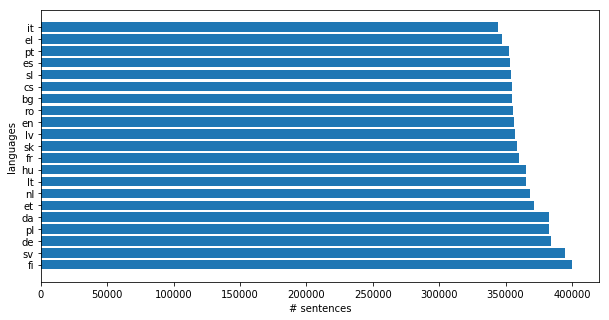

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 10, 5

lines = !wc -l -w {output_train_folder}/*.txt
print(lines[-1])
lines = [line.split() for line in lines[:-1]]
sents = sorted(((line[-1].split("/")[-1][:2],
                 int(line[0])) for line in lines), key=lambda x: -x[1])
keys, sents = zip(*sents)

plt.barh(range(len(keys)), sents, align='center');
plt.yticks(range(len(keys)), keys);
plt.xlabel('# sentences');
plt.ylabel('languages');

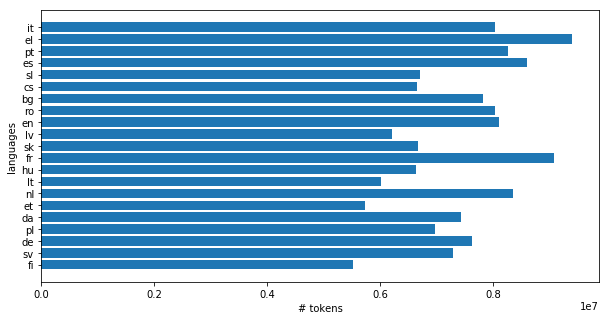

In [7]:
words = {line[-1].split("/")[-1][:2]: int(line[1]) for line in lines}
keys, sents = zip(*[(key, words[key]) for key in keys])

plt.barh(range(len(keys)), sents, align='center');
plt.yticks(range(len(keys)), keys);
plt.xlabel('# tokens');
plt.ylabel('languages');

## Language Identification

[Jauhiainen et al. (2018)](https://arxiv.org/abs/1804.08186) present a comprehensive survey of various approaches taken in the task of language identification and classification, including the notion of domain-independent identification mentioned above. They list numerous techniques, among which linear methods remain most efficient.

Due to the availability of a large training corpus, the [`fastText`](https://github.com/facebookresearch/fastText) model seems as a good fit because of fast implementation, which allows processing the entire multilingual parallel subcorpus (155M tokens) in feasible time (3.5 minutes on 2,3 GHz Intel Core i7). `fastText` is a linear bag of words classifier that constructs sentence representation by averaging constituent word vectors (in turn, bags of subword vectors) and yields class probabilities using either softmax or hierarchical softmax ([Zolotov, 2016](https://arxiv.org/abs/1702.05531)).

`fastText`'s developers describe its use for language identification and report the accuracy of $98.7\%$ on European Governance Papers ([Grave et al. (2018)](https://arxiv.org/pdf/1802.06893.pdf)).
`fastText` has also been used in dialect identification by [Çöltekin and Rama (2016)](http://coltekin.net/cagri/papers/coltekin2016dsl.pdf) where it showed suboptimal results (probably due to the difficulty of the task for dialects and closely related languages, as well as smaller training data).

#### Baseline: basic dictionary
As a baseline, we use a simple word count based approach where each unique token is annotated by the most frequent language it occurred in, and at the inference time, a test sentence is assigned the label of the majority of its constituent words (ties are broken arbitrarily). If the majority of words are unseen in the training set, the sentence is tagged with the `UNK` label.

This model relies heavily on the training set being diverse enough in terms of vocabulary, and there is a memory trade-off depending on a word frequency threshold ($O(V)$ where $V$ is the number of unique tokens in the corpus with frequency higher than the cut, e.g., 2M for the whole parallel corpus without setting a threshold).

In [8]:
from baseline import Baseline

example = Baseline()
example._vocab = {"this": "en", "is": "en", "a": "en", "house": "en",
                  "das": "de", "ist": "de", "ein": "de", "haus": "de"}
example.predict([["this", "is", "a", "oov"],
                 ["das", "ist", "ein", "oov"],
                 ["many", "out", "of", "vocab"]])

['en', 'de', 'UNK']

#### fastText: linear bag-of-words

`fastText` can be downloaded and installed from [here](https://github.com/facebookresearch/fastText).

Let's now prepare the dataset for the training of a fastText classification model. We will need to prepend labels (language id) to each example, concatenate all files together, and shuffle them.

In [9]:
LABEL_PREFIX = "__label__"
fast_train_folder = "train_fast"
if not os.path.isdir(fast_train_folder):
    os.makedirs(fast_train_folder, exist_ok=True)
    for lang in langs:
        !sed 's/^/{LABEL_PREFIX}{lang} /' {output_train_folder}/{lang}.txt > {fast_train_folder}/{lang}.txt
    !cat {fast_train_folder}/*.txt | gshuf > "all_train_labeled_shuf.txt"

Moreover, I will secure some of the training data for validation purposes (since the data are randomly shuffled, I assume that the last $X\%$ of rows also represent the original training distribution).

In [10]:
def prep_data(train_size=None, dev_proportion=0.1, name=""):
    """Divides the data file into separate train and dev set files."""
    train_set, dev_set = f"train_{name}.txt", f"dev_{name}.txt"
    if not train_size:
        total_lines = !wc -l < "all_train_labeled_shuf.txt"
        train_size = int(total_lines[0])
        
    if dev_proportion < 1.0:  # percentage         
        dev = int(train_size * dev_proportion)
        train = train_size - dev
        assert train + dev == train_size, (train + dev, train_size)
    else:
        dev = dev_proportion
        train = train_size


    print("Lines in train:", train)
    print("Lines in dev:", dev)

    !head -n {train} "all_train_labeled_shuf.txt" > {train_set}
    !tail -n {dev} "all_train_labeled_shuf.txt" > {dev_set}
    return train_set, dev_set

#### Training a baseline model

We will start with a baseline model (word count threshold is 2) and see its performance on a dev set.
(**NB**: The corpus is quite large, so for initial experiments I will limit the maximum number of sentences per language.)

In [11]:
from sklearn.metrics import accuracy_score
from baseline import read_labeled_sents

MAX_LINES_PER_LANG = 500  # * 21 = 10500 lines
train_set, dev_set = prep_data(MAX_LINES_PER_LANG * len(langs),
                               1000, name="default")

Lines in train: 10500
Lines in dev: 1000


In [12]:
%%time
dev_labels, dev_sents = read_labeled_sents(dev_set)
baseline = Baseline(train_set, min_count=2)
base_acc = accuracy_score(dev_labels, baseline.predict(dev_sents))
print("Dev acc: {:.3f}".format(base_acc))

Dev acc: 0.957
CPU times: user 416 ms, sys: 20.5 ms, total: 436 ms
Wall time: 435 ms


#### Training a (default) fastText classification model

For `fastText`, I will start with a model trained with the [default fastText hyperparameters](https://fasttext.cc/docs/en/options.html), test its performance on a dev set, and see if it can be improved.

```
The following arguments for the dictionary are optional:
  -minCount           minimal number of word occurrences [5]
  -minCountLabel      minimal number of label occurrences [0]
  -wordNgrams         max length of word ngram [1]
  -bucket             number of buckets [2000000]
  -minn               min length of char ngram [3]
  -maxn               max length of char ngram [6]
  -t                  sampling threshold [0.0001]
  -label              labels prefix [__label__]

  The following arguments for training are optional:
  -lr                 learning rate [0.05]
  -lrUpdateRate       change the rate of updates for the learning rate [100]
  -dim                size of word vectors [100]
  -ws                 size of the context window [5]
  -epoch              number of epochs [5]
  -neg                number of negatives sampled [5]
  -loss               loss function {ns, hs, softmax} [ns]
  -thread             number of threads [12]
  -pretrainedVectors  pretrained word vectors for supervised learning []
  -saveOutput         whether output params should be saved [0]
```

In [13]:
%%time
!./fastText_cmd/fasttext supervised -input {train_set} -output model_default.ft -loss hs 1> log_default.ft 2> err_default.ft

CPU times: user 49 ms, sys: 21.4 ms, total: 70.4 ms
Wall time: 3.67 s


In [14]:
%%time
!./fastText_cmd/fasttext test model_default.ft.bin {dev_set}

N	1000
P@1	0.923
R@1	0.923
Number of examples: 1000
CPU times: user 4.1 ms, sys: 8.29 ms, total: 12.4 ms
Wall time: 199 ms


#### Hyperparameter grid search

As mentioned earlier, it would be interesting to see how changing $n$ in word and character n-grams would affect a model's performance. For this, I will perform a brute-force grid search over a few possible values which intuitevly seem reasonable. (There is a problem with fixing the random seed due to parallel processing by `fastText`, so the observed differences in accuracy do not necessarily indicate a significant difference).

In [15]:
grid_train_set, grid_dev_set = train_set, dev_set

In [16]:
from sklearn.model_selection import ParameterGrid

def grid_search(train, dev, save_best_model=False):
    param_grid = [
        {
            'lr': [0.05],
            'dim': [32, 128],
            'ws': [5],
            'epoch': [5],
            'neg': [5],
            'wordNgrams': [1, 2, 3],
            'loss': ['hs'],
            'maxn': [0, 6],
            'minn': [0, 4],
            'minCount': [2, 10],
            'lrUpdateRate': [100],
        }
    ]
    grid = list(ParameterGrid(param_grid))
    grid_size = len(grid)
    print('#Parameters:', grid_size)
    best_result, best_params = -1, None
    for i, p in enumerate(grid, start=1):
        if i % (grid_size // 3) == 0:
            print("{}/{}".format(i, grid_size))
        if p["maxn"] < p["minn"]:
            continue
        !./fastText_cmd/fasttext supervised -input {train} -output model_{i}.ft -epoch {p["epoch"]} -dim {p["dim"]} -minCount {p["minCount"]} -neg {p["neg"]} -lr {p["lr"]} -ws {p["ws"]} -wordNgrams {p["wordNgrams"]} -loss {p["loss"]} -lrUpdateRate {p["lrUpdateRate"]} -maxn {p["maxn"]} -minn {p["minn"]} 1> ft.log 2> ft.err
        _, pr, re, _ = !./fastText_cmd/fasttext test model_{i}.ft.bin {dev}
        pr, re = [float(metric.split("\t")[1]) for metric in (pr, re)]
        
        if pr > best_result:
            diff = {param: val for param, val in p.items()
                    if val != best_params[param]} if best_params else None
            print("==> Better:\t{:.2%}\t".format(pr),
                  sorted(diff.items()) if diff else sorted(p.items()))
            best_params, best_result = p, pr
            if save_best_model:
                !mv model_{i}.ft.bin best_model.ft.bin
                !mv model_{i}.ft.vec best_model.ft.vec
                
        !rm model_{i}.ft.bin
        !rm model_{i}.ft.vec
    return best_params

In [17]:
best_params = grid_search(grid_train_set, grid_dev_set)
print(best_params)

#Parameters: 48
==> Better:	86.30%	 [('dim', 32), ('epoch', 5), ('loss', 'hs'), ('lr', 0.05), ('lrUpdateRate', 100), ('maxn', 0), ('minCount', 2), ('minn', 0), ('neg', 5), ('wordNgrams', 1), ('ws', 5)]
==> Better:	91.10%	 [('minCount', 10)]
16/48
32/48
48/48
{'dim': 32, 'epoch': 5, 'loss': 'hs', 'lr': 0.05, 'lrUpdateRate': 100, 'maxn': 0, 'minCount': 10, 'minn': 0, 'neg': 5, 'wordNgrams': 1, 'ws': 5}


It seems that with the current amount of training data, character n-grams with $n$ from 3 to 6 perform best, while a unigram word model performs comparably to larger n-grams.

Therefore, for the "final" model we will use the default parameters.

In [18]:
model_final = "model_default.ft.bin"

## Evaluation

For evaluation we will use the accuracy metric, overall and per each label.

In [19]:
!cut -d " " -f2- {TEST_SET} > unlabel_{TEST_SET}

In [20]:
%%time
gold_labels, test_sents = read_labeled_sents(TEST_SET)
print(list(zip(gold_labels[:2], test_sents[:2])))
baseline_pred_labels = baseline.predict(test_sents)

[('__label__bg', ['quot', 'европа', 'quot', 'не', 'трябва', 'да', 'стартира', 'нов', 'конкурентен', 'маратон', 'и', 'изход', 'с', 'приватизация']), ('__label__bg', ['cs', 'най', 'голямата', 'несправедливост', 'на', 'сегашната', 'обща', 'селскостопанска', 'политика', 'е', 'фактът', 'че', 'субсидиите', 'се', 'разпределят', 'неравностойно', 'и', 'несправедливо', 'между', 'старите', 'и', 'новите', 'държави', 'членки'])]
CPU times: user 434 ms, sys: 97.9 ms, total: 532 ms
Wall time: 531 ms


In [21]:
%%time
pred_labels = !./fastText_cmd/fasttext predict {model_final} unlabel_{TEST_SET}

CPU times: user 128 ms, sys: 71.7 ms, total: 200 ms
Wall time: 351 ms


In [22]:
from sklearn.metrics import classification_report

print("BASELINE", MAX_LINES_PER_LANG * len(langs), "examples")
print(classification_report(gold_labels, baseline_pred_labels, digits=3))

print("FASTTEXT", MAX_LINES_PER_LANG * len(langs), "examples")
print(classification_report(gold_labels, pred_labels, digits=3))

BASELINE 10500 examples
             precision    recall  f1-score   support

        UNK      0.000     0.000     0.000         0
__label__bg      1.000     0.999     0.999      1000
__label__cs      0.948     0.949     0.949      1000
__label__da      0.987     0.977     0.982      1000
__label__de      0.985     0.999     0.992      1000
__label__el      0.993     1.000     0.997      1000
__label__en      0.985     0.999     0.992      1000
__label__es      0.965     0.996     0.980      1000
__label__et      0.993     0.955     0.973      1000
__label__fi      0.976     0.973     0.974      1000
__label__fr      0.992     0.990     0.991      1000
__label__hu      0.984     0.994     0.989      1000
__label__it      0.989     0.983     0.986      1000
__label__lt      0.993     0.966     0.979      1000
__label__lv      0.987     0.985     0.986      1000
__label__nl      0.996     0.994     0.995      1000
__label__pl      0.990     0.977     0.983      1000
__label__pt      0.97

With the training set size of 500 * 21 = 10500 sentences, `fastText` is still behind the baseline model in terms of accuracy.

#### Training data size

Now, it would be interesting to see when exactly (on how much training data) the models start to perform reasonably well. The following is experiments on that, with the best/default parameters for fastText -- except for the minimum count of words which is set dynamically based on the training set size (and respective vocabulary size). Evaluation is performed on a dev set.

In [23]:
%%capture
from sklearn.metrics import accuracy_score
from baseline import Baseline, read_labeled_sents

dev_size = 300 * len(langs)
dev_plot, train_plot = "dev_plot.txt", "train_plot.txt"
!tail -n {dev_size} "all_train_labeled_shuf.txt" > {dev_plot}
!cut -d " " -f2- {dev_plot} > unlabel_{dev_plot}

dev_labels, dev_sents = read_labeled_sents(dev_plot)

p = best_params if model_final != "model_default.ft.bin" else None
acc_scores, acc_scores_base = [], []

# will use minCount [1,2,10] based on the train set size
n = len(langs)
sizes = ([(i, 1) for i in range(1 * n, 50 * n, 25 * n)] +
         [(i, 2) for i in range(150 * n, 500 * n, 30 * n)] +
         [(i, 10) for i in range(501 * n, 5000 * n, 501 * n)])

for size, min_count in sizes:
    !head -n {size} "all_train_labeled_shuf.txt" > {train_plot}
    try:
        !./fastText_cmd/fasttext supervised -input {train_plot} -output model_{size}.ft -minCount {min_count} 2> tmp.log
        preds = !./fastText_cmd/fasttext predict model_{size}.ft.bin unlabel_{dev_plot}
        curr = accuracy_score(dev_labels, preds)
        acc_scores.append(curr)
        acc_scores_base.append(accuracy_score(
            dev_labels, Baseline(train_plot, min_count=2).predict(dev_sents)));
    except ValueError as e:
        print(e)
    finally:
        !rm model_{size}.ft*

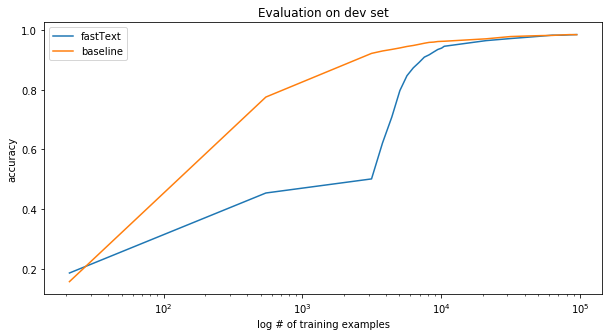

In [24]:
sizes, _ = zip(*sizes)
plt.plot(sizes, acc_scores);
plt.plot(sizes, acc_scores_base);
plt.xscale("log");
plt.legend(['fastText', 'baseline']);
plt.ylabel("accuracy");
plt.xlabel("log # of training examples")
plt.title("Evaluation on dev set");

In [30]:
print(sizes)

(21, 546, 3150, 3780, 4410, 5040, 5670, 6300, 6930, 7560, 8190, 8820, 9450, 10080, 10521, 21042, 31563, 42084, 52605, 63126, 73647, 84168, 94689)


A similar plot for the test set:

In [25]:
%%capture
from sklearn.metrics import accuracy_score
from baseline import Baseline, read_labeled_sents

dev_labels, dev_sents = read_labeled_sents(TEST_SET)

p = best_params if model_final != "model_default.ft.bin" else None
acc_scores, acc_scores_base = [], []

n = len(langs)
sizes = ([(i, 1) for i in range(1 * n, 50 * n, 25 * n)] +
         [(i, 2) for i in range(150 * n, 500 * n, 30 * n)] +
         [(i, 5) for i in range(501 * n, 5000 * n, 501 * n)])

for size, min_count in sizes:
    !head -n {size} "all_train_labeled_shuf.txt" > {train_plot}
    try:
        !./fastText_cmd/fasttext supervised -input {train_plot} -output model_{size}.ft -minCount {min_count} 2> tmp.log
        preds = !./fastText_cmd/fasttext predict model_{size}.ft.bin unlabel_{TEST_SET}
        curr = accuracy_score(dev_labels, preds)
        acc_scores.append(curr)
        acc_scores_base.append(accuracy_score(dev_labels, Baseline(train_plot, min_count=2).predict(dev_sents)));
    except ValueError as e:
        print(e)
    finally:
        !rm model_{size}.ft*

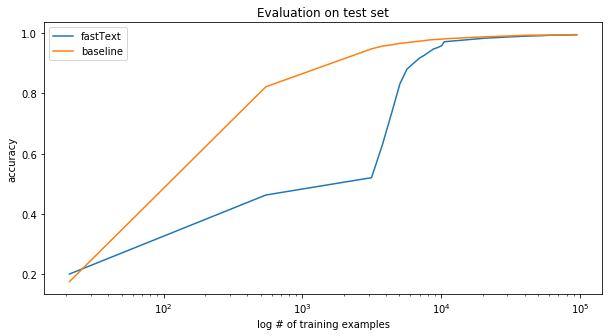

In [26]:
sizes, _ = zip(*sizes)
plt.plot(sizes, acc_scores);
plt.plot(sizes, acc_scores_base);
plt.xscale("log");
plt.legend(['fastText', 'baseline']);
plt.ylabel("accuracy");
plt.xlabel("log # of training examples")
plt.title("Evaluation on test set");

Final evaluation of a `fastText` model trained on a large-scale dataset (using hierarchical softmax) with 7.6M lines:

In [27]:
train_set, _ = prep_data(None, 2, name="large")

Lines in train: 7664366
Lines in dev: 2


In [28]:
%%time
!./fastText_cmd/fasttext supervised -input {train_set} -output model_large.ft -loss hs 1> log_large.log 2> err_large.log
print("")


CPU times: user 3.23 s, sys: 877 ms, total: 4.11 s
Wall time: 3min 30s


In [29]:
!./fastText_cmd/fasttext test model_large.ft.bin {TEST_SET}
!rm model_large.ft.*

N	21000
P@1	0.999
R@1	0.999
Number of examples: 21000


## Conclusions

The goal of the challenge is to train a model to classify sentences as belonging to one of 21 languages spoken in the EU, based on the provided training (7.6M sentences) and test (21k lines/sentences) sets taken from the EuroParl corpus, so both of the sets are from the same domain.

For this task, the training corpus is processed in such a way that only documents available in all the 21 languages are sampled (to avoid classification based on textual topics), i.e., only its parallel multilingual subcorpus; lines are split further into sentences (punctuation based), sentences are deduplicated, tokenized (with a non language-specific tokenizer), and stripped from punctuation and digits.

We compare two possible ways of language identification based on lexical features (words):
1. baseline: a basic dictionary approach, where each unique token from a training corpus is assigned the most frequent language tag, so while predicting, a sentence is represented as a sequence of labels corresponding to constituent words, and the majority label is chosen as the final language tag;
2. `fastText`: a bag-of-words logistic regression classifier calculating sentence representations based on subword vectors.

On a limited subset of training corpora, baseline outperforms `fastText` (accuracy 98% and 95%, respectively), but the latter is much faster.

Finally, experiments were undertaken to see the effect of adding more training data. Although `fastText` generally does not outperform the baseline model on datasets less with than 10k sentences (or ~500 instances per class), its accuracy increases dramatically when trained on larger corpora, with 99.9% for the entire training dataset.